This notebook processes the JSON outputs of the pipeline scripts.
Some scripts were run in multiple jobs on a cluster, in that case it loads many JSON files from a directory.
Note that the ipy kernel process for this notebook may require around 16 GB of memory.

## Table of contents
- List chains (ah-chains-uniprot)<!--(#List-chains)-->
- Filter structures (ah-filter-structures)<!--(#Filter-structures)-->
- Make pairs LCS (ah-make-pairs)<!--(#Make-pairs-LCS)-->
- Run analyses (ah-run-analyses)<!--(#Run-analyses)-->

links don't work on gh for ipynb like in md...

In [159]:
import glob
import json
from pathlib import Path
import pandas as pd

# you can download the gzipped results, see README, and set this path accordingly
OUTPUT_ROOT = Path('/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/2022-04-29')

## List chains

In [160]:
chains = pd.read_json(OUTPUT_ROOT / 'chains_uniprot/chains.json')
print('chains:', len(chains))
print('unique structures:', chains.pdb_code.nunique())
chains

chains: 595878
unique structures: 170634


,uniprotkb_id,pdb_code,chain_id,uniprot_group_size
0,P00720,161l,A,886
1,P00720,152l,A,886
2,P00720,166l,A,886
3,P00720,159l,A,886
4,P00720,113l,A,886
...,...,...,...,...
595873,O67035,7f3e,H,12
595874,O67035,7f3e,I,12
595875,O67035,7f3e,J,12
595876,O67035,7f3e,K,12


## Filter structures

In [161]:
from apo_holo_structure_stats.pipeline.utils.json import read_jsons_with_seqs

filtered__json_folder = OUTPUT_ROOT / 'filter/filter_output.json.d'

df = read_jsons_with_seqs(filtered__json_folder.glob('*'))
df = df.drop(columns='sequence')


loading filter_output.json559: 700/700
concatenating...
done.


In [162]:
print('passed chains:', len(df))
print('passed unique structures:', df.pdb_code.nunique())
df.describe(include='all')


passed chains: 249697
passed unique structures: 112635


,uniprotkb_id,pdb_code,uniprot_group_size,path,chain_id,is_holo,resolution,_exptl.method
count,249697,249697,249697.000000,249697,249697,249697,249697.000000,249697
unique,29386,112635,NaN,118876,350,2,NaN,4
top,P0DTD1,7bgl,NaN,../input/pdb_structs365/7rwt.cif.gz,A,True,NaN,X-RAY DIFFRACTION
freq,1490,78,NaN,60,108692,163523,NaN,246495
mean,NaN,NaN,122.077954,NaN,NaN,NaN,1.970795,NaN
std,NaN,NaN,260.245707,NaN,NaN,NaN,0.338090,NaN
min,NaN,NaN,2.000000,NaN,NaN,NaN,0.480000,NaN
25%,NaN,NaN,8.000000,NaN,NaN,NaN,1.750000,NaN
50%,NaN,NaN,25.000000,NaN,NaN,NaN,2.000000,NaN
75%,NaN,NaN,101.000000,NaN,NaN,NaN,2.240000,NaN


### Compute upper bound on the count of a-h pairs (for each uniprot group - accession):
i.e. potential pairs – the pairs for which the LCS will be computed.

In [163]:
by_unp = df.groupby('uniprotkb_id')
holos_by_group = by_unp['is_holo'].sum()
apos_by_group = by_unp['is_holo'].count() - holos_by_group

ub_pairs_by_group = (apos_by_group * holos_by_group).rename('upper_bound_on_pairs')
print('ub on all pairs (potential pairs):', ub_pairs_by_group.sum())
ub_pairs_by_group.describe()


ub on all pairs (potential pairs): 2690740


count     29386.000000
mean         91.565371
std        3637.177809
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      510925.000000
Name: upper_bound_on_pairs, dtype: float64

### Plot the distribution of pair counts within uniprot groups
Using ecdf – empirical cumulative distribution function.

And show the reduced size of the dataset if we kept only uniprot groups with < upper_clip pairs.

clip: 10 ub_pairs: 56317 ecdf:  0.8668
clip: 100 ub_pairs: 210113 ecdf:  0.9656
clip: 1000 ub_pairs: 557263 ecdf:  0.9932
clip: inf ub_pairs: 2690740 ecdf:  0.0000


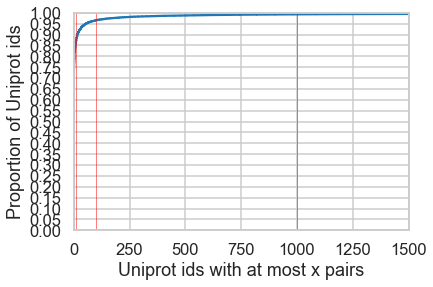

In [164]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(ub_pairs_by_group)
ax.set(xlim=(0, 1500))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylabel('Proportion of Uniprot ids')
ax.set_xlabel('Uniprot ids with at most x pairs')


upper_clip = [10, 100, 1000, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(ub_pairs_by_group.to_numpy()), np.linspace(0, 1, len(ub_pairs_by_group), endpoint=False)

for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'ub_pairs:', ub_pairs_by_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')

plt.grid(visible=True)
plt.show()


## Make Pairs LCS

In [165]:
import pandas as pd
import json

In [166]:
json_filename = OUTPUT_ROOT / 'make_pairs/pairs.json'
with open(json_filename) as f:
    potential_pairs = pd.json_normalize(json.load(f))


In [167]:
potential_pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06
mean,1.377614e+02,3.634823e+01,4.901014e+01,6.345996e+01,2.641469e+01,3.704527e+01
std,1.182538e+02,7.351079e+01,8.688338e+01,7.829397e+01,5.007045e+01,6.274535e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.160000e+02,2.000000e+00,4.000000e+00,4.100000e+01,0.000000e+00,0.000000e+00
75%,1.960000e+02,4.600000e+01,7.800000e+01,1.030000e+02,3.400000e+01,5.800000e+01
max,1.524000e+03,2.115000e+03,1.342000e+03,1.096000e+03,1.068000e+03,8.950000e+02


In [168]:
print(len(potential_pairs))
pairs = potential_pairs[potential_pairs['lcs_result.mismatches'] == 0]
print(len(pairs))

2690740
1016458


In [169]:
len(pairs[pairs['lcs_result.length'] < 50])
# I will remove those from results in # Run analyses
# (and the shortest give errors in run_analyses (if all are unobserved - 0 residues), but that's ok..)

791

In [170]:
pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,1.016458e+06,1.016458e+06,1.016458e+06,1016458.0,1016458.0,1016458.0
mean,2.116836e+02,3.174208e+00,4.544811e+00,0.0,0.0,0.0
std,1.086958e+02,1.582565e+01,2.107452e+01,0.0,0.0,0.0
min,3.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,1.290000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
50%,1.690000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
75%,3.050000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
max,1.524000e+03,5.720000e+02,9.050000e+02,0.0,0.0,0.0


In [171]:
# todo join with unp ids and find out the distribution in groups.
# if same as potential pairs or not.
chains = pd.read_json(OUTPUT_ROOT / 'chains_uniprot/chains.json')
pairs = pairs.merge(chains.set_index(['pdb_code', 'chain_id']), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

In [172]:
pairs.columns

Index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo',
       'lcs_result.length', 'lcs_result.i1', 'lcs_result.i2',
       'lcs_result.mismatches', 'lcs_result.leading_mismatches',
       'lcs_result.trailing_mismatches', 'uniprotkb_id', 'uniprot_group_size'],
      dtype='object')

In [173]:
pairs_per_group = pairs.groupby('uniprotkb_id').size()
pairs_per_group.describe()

count      6408.000000
mean        158.843477
std        3077.140315
min           1.000000
25%           2.000000
50%           6.000000
75%          18.000000
max      134404.000000
dtype: float64

clip: 10 pairs: 38368 ecdf:  0.6273
clip: 100 pairs: 121870 ecdf:  0.9213
clip: 200 pairs: 159623 ecdf:  0.9529
clip: 1700 pairs: 317710 ecdf:  0.9922
clip: inf pairs: 1017869 ecdf:  0.0000


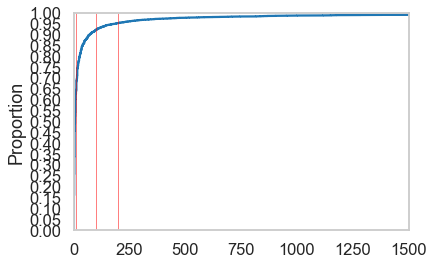

In [174]:

from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(pairs_per_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 200, 1700, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(pairs_per_group.to_numpy()), np.linspace(0, 1, len(pairs_per_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'pairs:', pairs_per_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')


[(0.0, 30.0)]

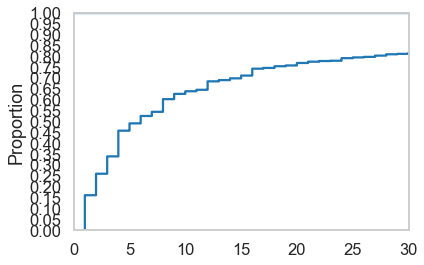

In [175]:
# zoom in
ax = sns.ecdfplot(pairs_per_group)
plt.axhline(np.max(ax.lines[0].get_ydata()))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set(xlim=(0, 30))

In [176]:
potential_pairs = potential_pairs.merge(chains.set_index(['pdb_code', 'chain_id']), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

potential_pairs_per_group = potential_pairs.groupby('uniprotkb_id').size()
potential_pairs_per_group.describe()

count      8452.000000
mean        323.051940
std        6780.096269
min           1.000000
25%           3.000000
50%           8.000000
75%          32.000000
max      510925.000000
dtype: float64

## Run analyses
This processes the results of analyses run on the apo-holo pairs (as generated above). For the residue-level analyses,
 only residues from the longest common substring (LCS) that are observed in both apo and holo structures are used.
The results are then processed to obtain the plots as in the paper [(Brylinski and Skolnick. 2008)](https://doi.org/10.1002/prot.21510).

First we load the json outputs from the jobs. Then, we construct wide-form pd.DataFrame with outputs from all the
chain-level analyses – e.g. RMSD between whole apo and holo chain, or the secondary structure identity between the two variants. We plot the chain-level analyses results.

Then we construct a wide-form dataset with two-domain arrangements analyses. With the RMSD of the two domains
 as a whole between the apo and holo forms. We also merge the RMSD of the individual domains to this dataframe. We plot
 the results afterwards.

The second type of json output `domain_info` contains the domain boundaries of the domains returned from the API, as
well as the observed segments with coordinates that were actually compared in the analyses. We then require, in
 the two-domain arrangements dataset, that the portion of the domains compared is at least 50%. The case
for less than 50% is the longest common substring of the chains cuts a domain short,
or, in part, that the residues in the domain are not well resolved in the structure (observed strictly in both
chains).

### Load outputs from `run_analyses`:

Load individual JSON files (outputs from the jobs run on a cluster) and concatenate them in to a python DataFrame.

In [2]:
from apo_holo_structure_stats.pipeline.utils.json import read_jsons_to_df
from apo_holo_structure_stats.core.json_deserialize import tuple_it, unfold_tuple_to_columns, tuple_columns

import pandas as pd

OUTPUT_PATH = OUTPUT_ROOT / 'run_analyses/output'

analyses_jsons = OUTPUT_PATH.rglob('output_apo_holo*')
domains_jsons = OUTPUT_PATH.rglob('output_domains*')

# for testing
# analyses_jsons = itertools.islice(analyses_jsons, 100)
# domains_jsons = itertools.islice(domains_jsons, 100)

analyses_df = read_jsons_to_df(analyses_jsons)
domain_info = read_jsons_to_df(domains_jsons)
domain_info = domain_info.applymap(tuple_it)

print(len(analyses_df))
print(len(domain_info))

loading output_apo_holo_2022-05-01T19:45:26.629409.json: 1500/1500
concatenating...
done.
loading output_domains_info_2022-05-01T19:45:26.629409.json: 1500/1500
concatenating...
done.
4981424
3878087


#### JSON structure
The structure of the loaded json in `analyses_df` is a flat records (objects) with the following columns:

In [125]:
print(analyses_df.columns)

Index(['analysis_name', 'args', 'kwargs', 'result', 'level_tag'], dtype='object')


Example record:

In [124]:
print(analyses_df.iloc[0])

analysis_name                   GetRMSD
args             [[2oxu, A], [4h84, B]]
kwargs                               {}
result                         0.522853
level_tag                   chain2chain
Name: 0, dtype: object


The structure of domain_info is similar.

Note that the structure of `args` column with the lists (or tuples) is very inconvenient, and it would be the first thing
 that should change when this project is updated. With pandas, objects/dicts with named args would be better. Next step
  is thus json-lines(for incremental writing and not storing everything in memory before dumping) (+ gzip) + object args.

1. Convert JSON lists in analyses `args` field to tuples.
    - Todo - in future it would be better to have the `args` object instead of lists and have the arguments named. (Would consume more memory and disk space, but the processing code would be cleaner.)
2. Create a dataframe for each analysis from the nested JSON containing all the results
    - it's actually for each analysis level now (conceptually different type of arguments)
        - levels are: chain2chain, domain2domain, 2DA and chain2DA2chain2DA
        -  however there is an exception - RMSD for chain2DA2chain2DA has different arguments than the hinge angle analysis. (todo maybe fix this - add new level.)

In [4]:
from collections import defaultdict

analyses_by_level = defaultdict(list)

for obj in analyses_df.itertuples():
    obj = obj._asdict()
    obj['args'] = tuple_it(obj['args'])  # json converted all my tuples to lists... won't work with hashing for joins..
    analyses_by_level[obj['level_tag']].append(obj)

# todo possibly del analyses_df

# convert analyses outputs to DataFrames
for k in analyses_by_level:
    analyses_by_level[k] = pd.DataFrame(analyses_by_level[k])


In [5]:
import math
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from apo_holo_structure_stats.core.json_deserialize import unfold_tuple_to_columns

In [129]:
# useful constants = column names
APO_CHAIN = ['pdb_code_apo', 'chain_id_apo']
HOLO_CHAIN = ['pdb_code_holo', 'chain_id_holo']
APO_DOMAIN = [*APO_CHAIN, 'domain_id_apo']
HOLO_DOMAIN = [*HOLO_CHAIN, 'domain_id_holo']
PAIR_ID = [*APO_CHAIN, *HOLO_CHAIN]

In [6]:

a_h_pairs = analyses_by_level['chain2chain'].drop_duplicates(['analysis_name', 'args'], keep=False)['args'].drop_duplicates()
# unfold the tuple of chains into two columns
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_chain','holo_chain'])
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_apo', 'chain_id_apo'], 'apo_chain')
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_holo', 'chain_id_holo'], 'holo_chain')

In [7]:
from apo_holo_structure_stats.pipeline.make_pairs_lcs import load_pairs_json, pairs_without_mismatches

pairs_filename = OUTPUT_ROOT / 'make_pairs/pairs.json'
pairs = pairs_without_mismatches(load_pairs_json(pairs_filename))
pairs_with_lengths = pairs[['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo']].assign(
    lcs_len=[lcs_result.length for lcs_result in pairs.lcs_result]
).set_index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo'])

In [8]:
# exclude chimeric chains (more uniprot ids for the chain mapped by SIFTS, therefore multiple times occuring in the results (could be removed at the `ah-chains-uniprot` stage, too)
a_h_pairs = pairs_with_lengths[~pairs_with_lengths.index.duplicated()]
# include uniprotkb_id information
chains_with_uniprots = pd.read_json(OUTPUT_ROOT / 'chains_uniprot/chains.json')
chains_with_uniprots = chains_with_uniprots.drop_duplicates(['pdb_code', 'chain_id']).set_index(['pdb_code', 'chain_id'])  # drop, so no dupes after merge
a_h_pairs = a_h_pairs.merge(chains_with_uniprots, left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

print(len(a_h_pairs))
a_h_pairs = a_h_pairs[a_h_pairs.lcs_len >= 50]
print(len(a_h_pairs))

1016162
1015371


### Label a_h_pairs as of multi-domain or single-domain proteins
`full_domains` are the CATH domains returned from the API.
`analyzed_domains` are the domains cropped to the observed residues (in both chains) and the LCS. The domain records (say domain 2oxuA00) in the dataframe may therefore be different in different pairs.

(Currently, the apo-chain domain is remapped to the holo-chain, as the definitions and in some cases the domain count can be different between apo and holo chains, this is the solution. Therefore, in `analyzed_domains`, the domain_id of the domain in the holo chain would be the apo domain id.)

In [9]:
# I forgot to not save duplicates in run_analyses for full domains, so remove them
full_domains = domain_info[domain_info['type'] == 'full_domain'].drop_duplicates('full_id').set_index('full_id', verify_integrity=True)

analyzed_domains = domain_info[domain_info['type'] == 'analyzed_domain']
# because of a mistake in removing chimeric chains (>1 uniprot for the chains), there are some left, remove them (should do it for each analysis here)
# there are only 600 of the dupes
analyzed_domains = analyzed_domains.drop_duplicates(['full_id', 'pair_id']).set_index(['full_id', 'pair_id'], verify_integrity=True)


full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
# full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
analyzed_domain_counts = analyzed_domains.groupby(by=['pdb_code', 'chain_id']).size()

print('single domain proteins', full_domain_counts[full_domain_counts == 1].count())
print('multi domain proteins', full_domain_counts[full_domain_counts > 1].count())

single domain proteins 46588
multi domain proteins 22604


In [10]:
full_domains

,type,pdb_code,chain_id,domain_id,spans,pair_id,spans_auth_seq_id
full_id,,,,,,,
"(2oxu, A, 2oxuA00)",full_domain,2oxu,A,2oxuA00,"((2, 159),)",NaN,NaN
"(4h84, B, 4h84B00)",full_domain,4h84,B,4h84B00,"((1, 159),)",NaN,NaN
"(5d2b, A, 5d2bA00)",full_domain,5d2b,A,5d2bA00,"((1, 159),)",NaN,NaN
"(5i0l, A, 5i0lA00)",full_domain,5i0l,A,5i0lA00,"((2, 159),)",NaN,NaN
"(5i0l, B, 5i0lB00)",full_domain,5i0l,B,5i0lB00,"((1, 159),)",NaN,NaN
...,...,...,...,...,...,...,...
"(5pg3, A, 5pg3A00)",full_domain,5pg3,A,5pg3A00,"((22, 136),)",NaN,NaN
"(5p0d, A, 5p0dA01)",full_domain,5p0d,A,5p0dA01,"((5, 174),)",NaN,NaN
"(5p0d, A, 5p0dA02)",full_domain,5p0d,A,5p0dA02,"((175, 330),)",NaN,NaN


In [11]:
# label single, multi domain pairs
a_h_pairs = a_h_pairs.merge(full_domain_counts.rename('domain_count'), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)
a_h_pairs.loc[a_h_pairs['domain_count'] == 1, 'domain_label'] = 'single domain'
a_h_pairs.loc[a_h_pairs['domain_count'] > 1, 'domain_label'] = 'multi domain'

print(len(a_h_pairs[a_h_pairs.domain_label == 'single domain']))
print(len(a_h_pairs[a_h_pairs.domain_label == 'multi domain']))

576887
244457


In [12]:
a_h_pairs

lcs_len uniprotkb_id  \
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                         
5b02         A            5b0i          A                  343       A0A010   
                                        C                  343       A0A010   
                          5b0j          C                  343       A0A010   
             C            5b0i          A                  343       A0A010   
                                        C                  343       A0A010   
...                                                        ...          ...   
5gtt         A            5wtz          A                  421       X5I2D7   
                          5wu0          A                  421       X5I2D7   
5h03         A            5h04          A                  419       X5I2D7   
                          5wtz          A                  419       X5I2D7   
                          5wu0          A                  419       X5I2D7   

                                                       uniprot_group_size  \
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                       
5b02         A            5b0i          A                              65   
                                        C                              65   
                          5b0j          C                              65   
             C            5b0i          A                              65   
                                        C                              65   
...                                                                   ...   
5gtt         A            5wtz          A                               5   
                          5wu0          A                               5   
5h03         A            5h04          A                               5   
                          5wtz          A                               5   
                          5wu0          A                               5   

                                                       domain_count  \
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                 
5b02         A            5b0i          A                         1   
                                        C                         1   
                          5b0j          C                         1   
             C            5b0i          A                         1   
                                        C                         1   
...                                                             ...   
5gtt         A            5wtz          A                         2   
                          5wu0          A                         2   
5h03         A            5h04          A                         2   
                          5wtz          A                         2   
                          5wu0          A                         2   

                                                        domain_label  
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                 
5b02         A            5b0i          A              single domain  
                                        C              single domain  
                          5b0j          C              single domain  
             C            5b0i          A              single domain  
                                        C              single domain  
...                                                              ...  
5gtt         A            5wtz          A               multi domain  
                          5wu0          A               multi domain  
5h03         A            5h04          A               multi domain  
                          5wtz          A               multi domain  
                          5wu0          A               multi domain  

[821344 rows x 5 columns]

### Create a wide-form dataset for all chain analyses
Note that this will keep only chain pairs that have a result for all the analyses. (However, SS is sometimes not present due to an API error.)

In [13]:
chain_analyses = a_h_pairs.reset_index()
# add column `args`, so we can pd.merge
chain_analyses['args'] = tuple_columns(
    tuple_columns(chain_analyses.pdb_code_apo, chain_analyses.chain_id_apo),
    tuple_columns(chain_analyses.pdb_code_holo, chain_analyses.chain_id_holo),
)

# add comparison of SS
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'CompareSecondaryStructure'].rename(columns={'result': 'ss_identity'})
print('ss analyses: ', len(df))
chain_analyses = chain_analyses.merge(df, on='args')
# add RMSD
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd'})
print('rmsd analyses: ', len(df))
chain_analyses = chain_analyses.merge(df, on='args')

chain_analyses = chain_analyses.set_index(a_h_pairs.index.names)
print(len(chain_analyses))
# remove duplicates (again introduced in the merges because of the chimeric chains)
chain_analyses = chain_analyses[~chain_analyses.index.duplicated()]
print(len(chain_analyses))

ss analyses:  1001835
rmsd analyses:  1015599
815575
814878


Here create non-redundant dataset with one pair for each uniprot group, for the visualization and interpretation.
If more pairs per uniprot, take the one with the longest LCS.

In [14]:
def one_pair_per_uniprot(df):
    # get max 'lcs_len' row from each group
    return df.sort_values('lcs_len', ascending=False).drop_duplicates(['uniprotkb_id'])

nr_chain_analyses = one_pair_per_uniprot(chain_analyses)
nr_chain_analyses

,,,,lcs_len,uniprotkb_id,uniprot_group_size,domain_count,domain_label,args,Index_x,analysis_name_x,kwargs_x,ss_identity,level_tag_x,Index_y,analysis_name_y,kwargs_y,rmsd,level_tag_y
pdb_code_apo,chain_id_apo,pdb_code_holo,chain_id_holo,,,,,,,,,,,,,,,,
2a68,D,2a6h,N,1524,Q8RQE8,107,6,multi domain,"((2a68, D), (2a6h, N))",417,CompareSecondaryStructure,{},0.965967,chain2chain,416,GetRMSD,{},0.895164,chain2chain
6g5g,A,6g5f,A,1291,P10844,49,1,single domain,"((6g5g, A), (6g5f, A))",2451,CompareSecondaryStructure,{},0.948357,chain2chain,2450,GetRMSD,{},0.967724,chain2chain
1muk,A,1mwh,A,1267,P0CK31,5,1,single domain,"((1muk, A), (1mwh, A))",683,CompareSecondaryStructure,{},0.990446,chain2chain,682,GetRMSD,{},0.191075,chain2chain
3e0c,A,3ei3,A,1140,Q16531,94,4,multi domain,"((3e0c, A), (3ei3, A))",4015,CompareSecondaryStructure,{},0.943452,chain2chain,4014,GetRMSD,{},3.055134,chain2chain
2be5,C,2a68,C,1119,Q8RQE9,121,6,multi domain,"((2be5, C), (2a68, C))",1527,CompareSecondaryStructure,{},0.950849,chain2chain,1526,GetRMSD,{},0.321621,chain2chain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6haj,A,6ha4,A,55,B6HWK0,5,1,single domain,"((6haj, A), (6ha4, A))",2447,CompareSecondaryStructure,{},0.890909,chain2chain,2446,GetRMSD,{},0.804056,chain2chain
4kgt,B,4kgt,A,55,P06654,65,1,single domain,"((4kgt, B), (4kgt, A))",3005,CompareSecondaryStructure,{},1.000000,chain2chain,3004,GetRMSD,{},0.749031,chain2chain
1r0g,A,6bd4,A,54,P00268,56,1,single domain,"((1r0g, A), (6bd4, A))",29,CompareSecondaryStructure,{},0.924528,chain2chain,28,GetRMSD,{},0.482628,chain2chain


In [15]:
nr_chain_analyses.to_json('nr_pairs.json')

Create a dataset for domain-to-domain analyses (now only RMSD)

In [ ]:
d2d_rmsd = analyses_by_level['domain2domain'].query('analysis_name == "GetRMSD"').drop_duplicates(['args'], keep=False)
# for merging, extract in new column only a-h tuple of (pdb_code, chain_id) from the a-h tuple of triples with also a
# domain_id
df = d2d_rmsd
df = unfold_tuple_to_columns(df, ['domain_apo', 'domain_holo'], 'args')
df = unfold_tuple_to_columns(df, APO_DOMAIN, 'domain_apo')
df = unfold_tuple_to_columns(df, HOLO_DOMAIN, 'domain_holo')
domain_rmsd = df.set_index(APO_DOMAIN + HOLO_DOMAIN)['result'].rename('domain_rmsd')

### Plots
Initialize plots:

In [16]:
from pathlib import Path

# sns.reset_orig()
sns.set_context('talk')
matplotlib.rcParams['figure.figsize'] = 8,6

plot_counter = 0
plot_path = Path('output_plots')
plot_path.mkdir(exist_ok=True)

def save_plot():
    global plot_counter
    plt.savefig(str(plot_path / f'paper_plot{plot_counter}.png'))
    plot_counter += 1

A-H Secondary structure identity in single/multi domain proteins (proteins myslej páry)
- join ss analysis with domain counts (decide what if # total domains different in pair or != 1)
histogram with bins for SS identity (2%)

Paper:
> 521 representative ligand-bound/
ligand-free pairs with lengths varying from 50 to 1392
residues was compiled. This results in 328 single-domain
proteins, 193 multiple-domain proteins, 487 individual
protein domains, and 311 two-domain arrangements.

Therefore as "individual domains" they mean only those from multi-domain proteins.

#### Plot secondary structure identity between apo and holo forms
- for apo-holo chain pairs
    - divided into single- and multi- domain chains

                                                       lcs_len uniprotkb_id  \
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                         
3abd         B            5xpu          A                  227       Q9UI95   
2viu         B            1htm          F                  138       P03437   
2fjy         B            1dqe          B                  137       P34174   
5d4l         A            5d4n          A                  108       D5X329   

                                                       uniprot_group_size  \
pdb_code_apo chain_id_apo pdb_code_holo chain_id_holo                       
3abd         B            5xpu          A                              43   
2viu         B            1htm          F                             129   
2fjy         B            1dqe          B                               9   
5d4l         A            5d4n          A                              14   

                                                       domain_

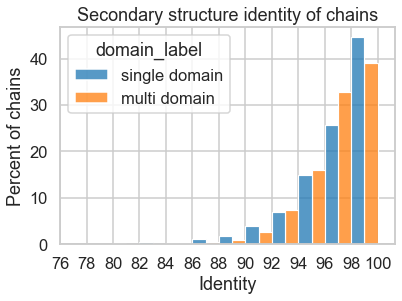

In [17]:
df = nr_chain_analyses

LOWER_DISPLAY_BOUND_ON_SS_IDENTITY = 0.76

outliers = df[df.ss_identity < LOWER_DISPLAY_BOUND_ON_SS_IDENTITY]
print(outliers)
print('outliers:', len(outliers))
print('all:', len(df))

def rounded_bins(a, binwidth):
    lower_bound = math.floor(np.min(a) / binwidth) * binwidth
    upper_bound = math.ceil(np.max(a) / binwidth) * binwidth

    return np.linspace(lower_bound, upper_bound, 1 + (int) ((upper_bound-lower_bound) / binwidth))

df['ss_identity__percent'] = df.ss_identity * 100
LOWER_DISPLAY_BOUND_ON_SS_IDENTITY *=100
BINWIDTH = 2
hue_order = ['single domain', 'multi domain']
ax = sns.histplot(df, x='ss_identity__percent', stat='percent', common_norm=False, hue='domain_label',
             hue_order=hue_order, multiple='dodge', bins=rounded_bins(df['ss_identity__percent'], BINWIDTH))
             # hue_order=hue_order, multiple='dodge', binwidth=BINWIDTH, binrange=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, 1))  # gate out outliers (148)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, None))
ax.set_title('Secondary structure identity of chains')
ax.set_xlabel('Identity')
ax.set_ylabel('Percent of chains')
save_plot()

#### Plot RMSD between apo and holo forms
- for apo-holo chain pairs
    - divided into single- and multi- domain chains
- for individual domains of multidomain chains (apo vs. holo)

isin
isin done


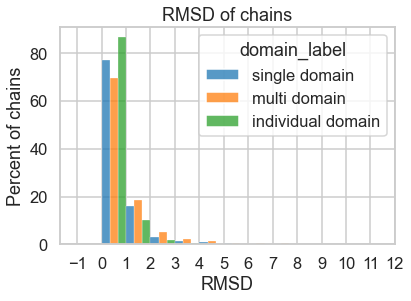

In [136]:
from pandas import MultiIndex
# extract the dataset of individual domains in multi-domain proteins
# todo is the from_frame sorted the same way? If it uses a stable sort then yes...
individual_domain_df = domain_rmsd[
    MultiIndex.from_frame(domain_rmsd.reset_index()[PAIR_ID]).isin(nr_chain_analyses[nr_chain_analyses.domain_label == 'multi domain'].index)
].to_frame()
individual_domain_df['domain_label'] = 'individual domain'

# concatenate the dataset for the plot
df = pd.concat([nr_chain_analyses, individual_domain_df.rename(columns={'domain_rmsd': 'rmsd'})], ignore_index=True)

BINWIDTH = 1
ax = sns.histplot(df, x='rmsd', stat='percent', common_norm=False, hue='domain_label', multiple='dodge',
                  bins=rounded_bins(df['rmsd'], BINWIDTH), hue_order=hue_order + ['individual domain'])
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(None, 12))
ax.set_title('RMSD of chains')
ax.set_xlabel('RMSD')
ax.set_ylabel('Percent of chains')
save_plot()

### Create a wide-form dataset for domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 10)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

In [100]:
from typing import NamedTuple

def get_pair_id(row: NamedTuple):
    return (
        (getattr(row, PAIR_ID[0]), getattr(row, PAIR_ID[1])),
        (getattr(row, PAIR_ID[2]), getattr(row, PAIR_ID[3])),
    )

def get_pair_id_column(df):
    return tuple_columns(
        tuple_columns(df[PAIR_ID[0]], df[PAIR_ID[1]]),
        tuple_columns(df[PAIR_ID[2]], df[PAIR_ID[3]]),
    )

def unfold_2DA_args(args_column):
    df = unfold_tuple_to_columns(args_column, ['apo_domains', 'holo_domains'])
    apo2DA_unfolded = unfold_tuple_to_columns(df['apo_domains'], ['d1', 'd2'])
    holo2DA_unfolded = unfold_tuple_to_columns(df['holo_domains'], ['d1', 'd2'])

    apo2DA_unfolded = unfold_tuple_to_columns(apo2DA_unfolded, ['pdb_code', 'chain_id', 'domain_id'], 'd1')
    holo2DA_unfolded = unfold_tuple_to_columns(holo2DA_unfolded, ['pdb_code', 'chain_id', 'domain_id'], 'd1')

    return dict(
        pdb_code_apo=apo2DA_unfolded['pdb_code'],
        chain_id_apo=apo2DA_unfolded['chain_id'],
        domain_1_id_apo=apo2DA_unfolded['domain_id'],
        domain_2_id_apo=[t[2] for t in apo2DA_unfolded['d2'].values],
        pdb_code_holo=holo2DA_unfolded['pdb_code'],
        chain_id_holo=holo2DA_unfolded['chain_id'],
        domain_1_id_holo=holo2DA_unfolded['domain_id'],
        domain_2_id_holo=[t[2] for t in holo2DA_unfolded['d2'].values],
    )

In [101]:

df = analyses_by_level['chain2DA2chain2DA'].drop_duplicates(['analysis_name', 'args'], keep=False)  # drop dupes due to chimeric, so no dupes when merging
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']


# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

print(len(hinge_df))
print(len(rmsd_df))
tda_analyses = rmsd_df.merge(hinge_df, on='args')
tda_analyses = tda_analyses.assign(**unfold_2DA_args(tda_analyses.args))



print('two-domain arrangements count (present in apo and holo)', len(tda_analyses))

258441
258441
two-domain arrangements count (present in apo and holo) 258441


In [102]:
tda_analyses = unfold_tuple_to_columns(tda_analyses, ['apo_domains', 'holo_domains'], 'args')

In [103]:
tda_analyses['pair_id'] = get_pair_id_column(tda_analyses)

In [104]:
# merge interface area
df = analyses_by_level['2DA']

interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea'].drop_duplicates(['args'], keep=False)  # drop dupes due to chimeric, so no dupes when merging
df = unfold_tuple_to_columns(interface_area, ['d1', 'd2', 'pair_id'], 'args')
interface_area['2DA_id'] = tuple_columns(df.d1, df.d2)
interface_area['pair_id'] = df['pair_id']
interface_area = interface_area.set_index(['2DA_id', 'pair_id'])

df = tda_analyses.merge(interface_area['result'].rename('apo_interface'), left_on=['apo_domains', 'pair_id'], right_index=True)
df = df.merge(interface_area['result'].rename('holo_interface'), left_on=['holo_domains', 'pair_id'], right_index=True)

# merge per-domain rmsd (2x)
df = df.merge(domain_rmsd, left_on=[*APO_CHAIN, 'domain_1_id_apo', *HOLO_CHAIN, 'domain_1_id_holo'], right_index=True)
df = df.merge(domain_rmsd, left_on=[*APO_CHAIN, 'domain_2_id_apo', *HOLO_CHAIN, 'domain_2_id_holo'], right_index=True, suffixes=('_d1', '_d2'))


In [108]:
tda_analyses = df

In [110]:
# todo jeste odfiltrovat < 200 A^2

# podivej se na ty domeny, (full spany) a lcs a spočítej přes min a max délku v lcs a celkovou
# pro obe domény? Ano, pro kazdy par 2DA. Merguj s make_lcs

# muzu zjisit pouze z full vs analyzed... Jinak bych si musel ukladat jeste label_seq_id start ve filter_structures
# nikoliv z full vs lcs
def compute_observed_ratio(analyzed_domain_spans, full_domain_spans):
    def get_length(spans):
        length = 0
        for start, end in spans:
            length += end - start + 1
        return length
    return get_length(analyzed_domain_spans) / get_length(full_domain_spans)


# celkem tam jsou 4 domény (2 v apu, 2 v holu). A chci, aby to platilo pro všechny 4.
# asi bych to nemergoval a dělal rovnou loc..

# create dataframe of cols which will be added to two_domain_arrangements
ratios = defaultdict(list)
for row in tda_analyses.itertuples():
    ad1, ad2 = row.apo_domains
    hd1, hd2 = row.holo_domains

    # todo no idea why the following does not work? Raises KeyError: "None of [Index(['1tgb', 'A', '1tgbA01'], dtype='object', name='full_id')] are in the [index]"
    # full_spans = full_domains.loc[ad1, 'spans']
    full_spans_d1 = full_domains.at[ad1, 'spans']
    full_spans_d2 = full_domains.at[ad2, 'spans']

    for colname, full_spans, d in zip(('ad1', 'ad2', 'hd1', 'hd2'), (full_spans_d1, full_spans_d2, full_spans_d1, full_spans_d2), (ad1, ad2, hd1, hd2)):
        analyzed_spans = analyzed_domains.at[(d, get_pair_id(row)), 'spans']
        ratios[colname].append(compute_observed_ratio(analyzed_spans, full_spans))

tda_analyses = tda_analyses.assign(**ratios)
# todo better name for observed ratio than ad1,...

In [111]:
tda_analyses.columns

Index(['Index_x', 'analysis_name_x', 'args', 'kwargs_x', 'rmsd_2DA',
       'level_tag_x', 'Index_y', 'analysis_name_y', 'kwargs_y', 'result',
       'level_tag_y', 'hinge_angle', 'translation_in_axis',
       'translation_overall', 'pdb_code_apo', 'chain_id_apo',
       'domain_1_id_apo', 'domain_2_id_apo', 'pdb_code_holo', 'chain_id_holo',
       'domain_1_id_holo', 'domain_2_id_holo', 'apo_domains', 'holo_domains',
       'pair_id', 'apo_interface', 'holo_interface', 'domain_rmsd_d1',
       'domain_rmsd_d2', 'ad1', 'ad2', 'hd1', 'hd2'],
      dtype='object')

Remove . Either way, those were probably already removed in the short domain removal.

Select 2DAs only from nr_a_h_pairs – representatives for each UNP accession. (This will by extension also remove those with too short LCS, as they were removed from a_h_pairs.

In [112]:
# remove data with short lcs (already removed in a_h_pairs) and (and duplicates due to chimeric)
tda_analyses = tda_analyses[pd.Series(get_pair_id_column(tda_analyses)).isin(set(get_pair_id_column(a_h_pairs.reset_index())))]
len(tda_analyses)

/var/folders/yd/d0qwckdj493c0xxb37j79t380000gn/T/ipykernel_59260/4145980984.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tda_analyses = tda_analyses[pd.Series(get_pair_id_column(tda_analyses)).isin(set(get_pair_id_column(a_h_pairs.reset_index())))]


258441

In [113]:
dupes = tda_analyses[tda_analyses.duplicated(subset=['args'])]
assert len(dupes) == 0

Remove 2DAs that don't have meet the threshold for a observed residues in a domain:

In [114]:
df = tda_analyses

OBSERVED_THRESHOLD = 0.5

# remove_data_with_short_domains
tda_analyses = df[
    (df.ad1 > OBSERVED_THRESHOLD)
     & (df.ad2 > OBSERVED_THRESHOLD)
     & (df.hd1 > OBSERVED_THRESHOLD)
     & (df.hd2 > OBSERVED_THRESHOLD)
]
print('valid two-domain arrangements count (present in apo and holo)', len(tda_analyses))

# df[~((df.ad1 > OBSERVED_THRESHOLD)
#      & (df.ad2 > OBSERVED_THRESHOLD)
#      & (df.hd1 > OBSERVED_THRESHOLD)
#      & (df.hd2 > OBSERVED_THRESHOLD))]

valid two-domain arrangements count (present in apo and holo) 255347
3115


Create nr dataset clustered by unp (works, because nr_chain_analyses are already clustered by it). I.e. select only two-domain arrangements present in the nr chains. This is good, because the nr chains are those selected with longest LCS for the uniprot, therefore there should be as many domains for the chains as possible.

In [ ]:
nr_tda_analyses = tda_analyses[pd.Series(get_pair_id_column(tda_analyses)).isin(set(nr_chain_analyses['args'])).to_numpy()]
print(len(nr_tda_analyses))


#### Hinge angle vs RMSD of two-domain arrangements

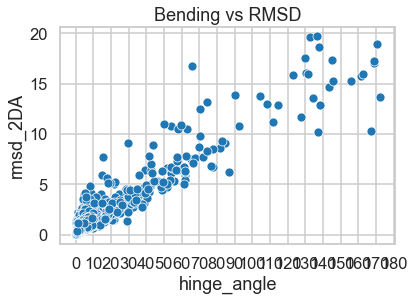

In [78]:
ax = sns.scatterplot(data=nr_tda_analyses, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))
ax.set_title('Bending vs RMSD')
save_plot()

#### Shear, as classified in the paper
- classified as RMSD value between 1 and 2 (RMSD of apo and holo two-domain arrangements)

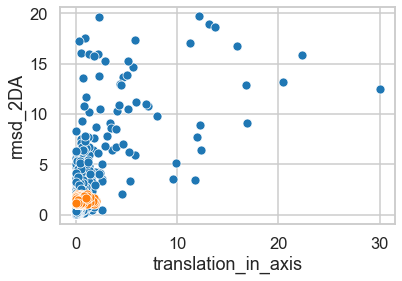

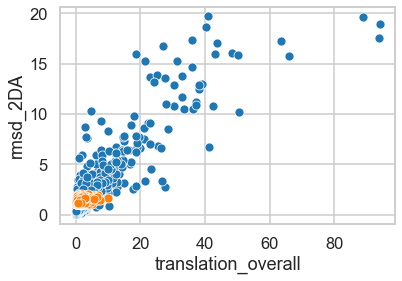

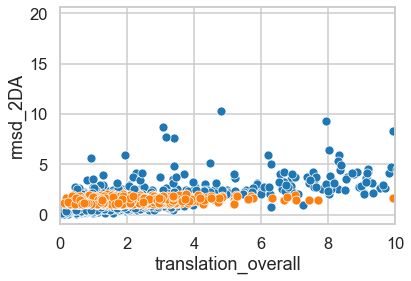

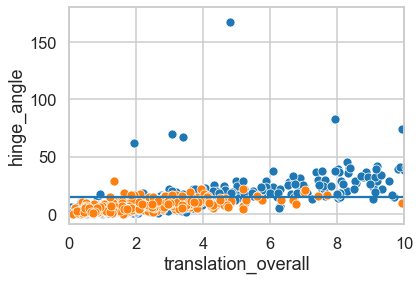

,hinge_angle,translation_overall,translation_in_axis,rmsd_2DA,domain_rmsd_d1,domain_rmsd_d2
189763,0.115350,0.097220,0.079158,1.17712,0.098124,1.295446
148726,2.155767,0.158865,0.078810,1.054831,0.873860,1.169762
142350,5.186707,0.164422,0.119843,1.66138,0.395109,2.087833
133469,2.592840,0.166126,0.150640,1.330382,1.676614,0.401054
103800,0.708864,0.173410,0.003376,1.101251,0.479931,1.477294
...,...,...,...,...,...,...
7161,19.514828,7.009366,0.688178,1.902689,0.502125,0.457708
7165,20.723837,7.034688,1.085837,1.428284,0.457708,0.385010
167055,16.063722,7.431678,0.745646,1.436743,0.541085,0.637999
798,16.907519,7.682538,1.233674,1.463513,0.826254,0.290631


In [116]:
df = nr_tda_analyses[:]

paper_shear = df[(1 < df.rmsd_2DA) & (df.rmsd_2DA < 2)]  # gather shears

# rmsd_2DA vs translation_in_axis
ax = sns.scatterplot(data=nr_tda_analyses, x='translation_in_axis', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_in_axis', y='rmsd_2DA')
plt.show()


# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=nr_tda_analyses, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
plt.show()

# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=nr_tda_analyses, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
ax.set(xlim=(0, 10))
plt.show()


ax = sns.scatterplot(data=nr_tda_analyses, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax.set(xlim=(0, 10))
ax.axhline(15)
plt.show()

paper_shear[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_d1', 'domain_rmsd_d2']].sort_values(by='translation_overall')

# all = all[all.rmsd_2DA > 1]
# all[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')


Show if shear as defined in the paper may contain also examples where rather only one domain accommodates the ligand (therefore raising rmsd of the two-domain arrangement as a whole. But no traslation between domains (corresponding to shear interface) would be in fact measured.

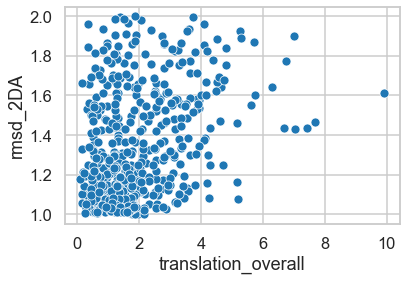

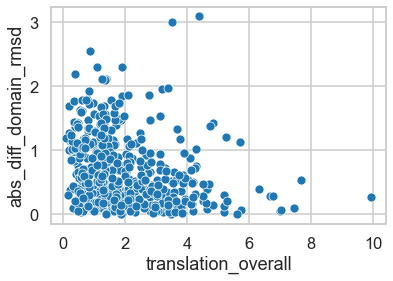

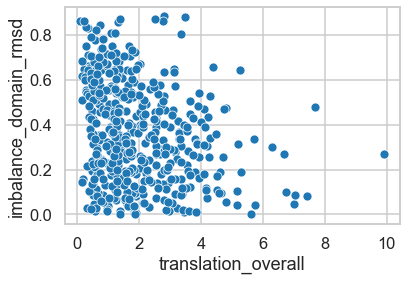

In [158]:
df = paper_shear
df['abs_diff_domain_rmsd'] = (df.domain_rmsd_d1 - df.domain_rmsd_d2).abs()
df['imbalance_domain_rmsd'] = (df.domain_rmsd_d1 - df.domain_rmsd_d2).abs() /  (df.domain_rmsd_d1 + df.domain_rmsd_d2)
sns.scatterplot(data=df, x='translation_overall', y='rmsd_2DA')
plt.show()
sns.scatterplot(data=df, x='translation_overall', y='abs_diff_domain_rmsd')
plt.show()
sns.scatterplot(data=df, x='translation_overall', y='imbalance_domain_rmsd')
plt.show()

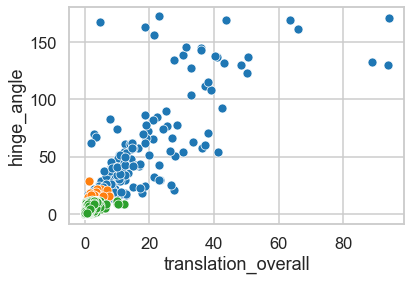

In [119]:
ax = sns.scatterplot(data=nr_tda_analyses, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=nr_tda_analyses[
    (nr_tda_analyses.translation_overall > 0.2) & (nr_tda_analyses.hinge_angle < 12)], x='translation_overall', y='hinge_angle')


#### Plot buried interface before and after binding

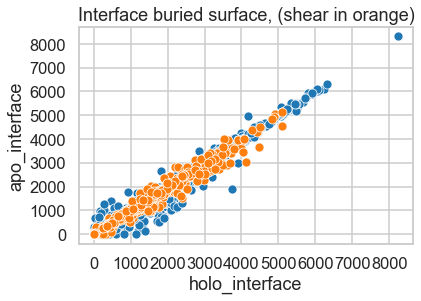

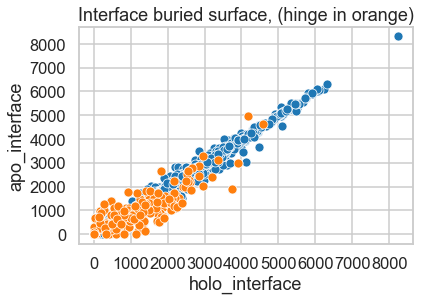

In [120]:
df = nr_tda_analyses

def show_all():
    ax = sns.scatterplot(data=nr_tda_analyses, x='holo_interface', y='apo_interface')
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))

# df = df.merge(hinge_df, left_on=['apo_domains', 'pair_id'], right_on=['apo_domains', 'pair_id'])

def show_shear():
    sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 15)], x='holo_interface', y='apo_interface')

def show_hinge():
    sns.scatterplot(data=df[(df.hinge_angle > 15)], x='holo_interface', y='apo_interface')

show_all()
show_shear()
plt.title('Interface buried surface, (shear in orange)')
save_plot()
plt.show()


show_all()
show_hinge()
plt.title('Interface buried surface, (hinge in orange)')
save_plot()
plt.show()
# todo udělat diagonálu

# df[df.apo_interface > 6000]
# 8300 outlier = large beta barrel 1pnz, 1kmo


Compared to the paper, it's estimated as larger.

2DA
prediktor large-scale motion type z apo interface buried

interface buried (apo) vs (bending)|(RMSD - opět 2DA-explicitně)
- scatter and histogram


#### Plot bending and buried interface

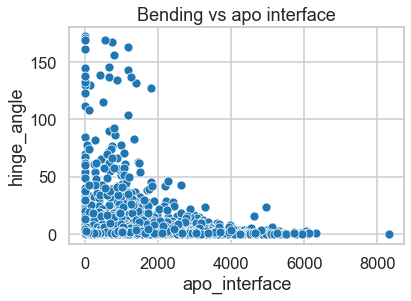

In [121]:

# to nefunguje, kdyz to neni v tom contextu, tak to nic nedělá
# sns.set_context("notebook", rc={"scatter.marker": ','})
#
# import matplotlib as mpl
# # mpl.rcdefaults()
# mpl.rc('scatter', marker='o')
# mpl.rc('lines', markersize=2)
# mpl.rc('figure', figsize=[12, 8])

# sns.set_theme()
ax = sns.scatterplot(data=nr_tda_analyses, x='apo_interface', y='hinge_angle')
ax.set_title('Bending vs apo interface')
save_plot()
# true shear dataset
# sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 12)], x='apo_interface', y='hinge_angle')
# mpl.rcdefaults()
# sns.set_context()

plt.rcParams['figure.figsize'] = [12, 8]We can see that domain interface area (in apo structure) indeed sets a limit on whether the domains can do a hinge motion. Hinge bending domain pairs with interface area larger than 2000 Å^2 were not observed.

The conclusion for shear, in the paper, holds too.
No lg scale dom. movements above 3550 A2 interface.

deducible by the
examination of a ligand-free structural form alone.
- mění se něco? Může to být víc deducible ještě z něčeho novýho, co máme ted k dispozici? Asi ne..

<AxesSubplot:xlabel='apo_interface', ylabel='rmsd_2DA'>

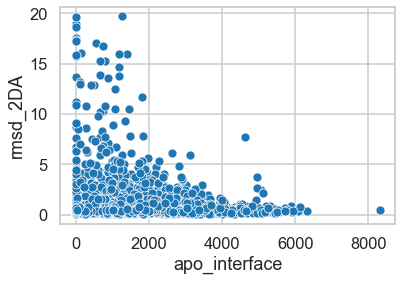

In [123]:
sns.scatterplot(data=nr_tda_analyses, x='apo_interface', y='rmsd_2DA')

### Errors while running jobs
Proč ~je~ bylo filů jen 385?
- u 7 jobů se nenainstaloval package (pip seaborn, pandas)?
- co ty zbylé? těch 8?

celkem 15 jsem nasel pomocí  `grep -e 'ERROR:[^a][^p]' run_analyses_fixed/job_script*`
takže všechny

vyřešil jsem to zatim pomocí metacentrum_scripts/submit_failed_run_analyses.py
- prostě spustím job znova..

Nevim, co to zpusobuje, mozna by to vyresil vetsi timeout v pipu?
Nektery chyby vypadaj zpusobeny 2 pipama, ale vzdy pouzivam `pip`, i u jeho upgradu, tak nevim, kde by mohl nastat rozdil
    - protoze pip se tam uspesne upgraduje, a pak to pise, ze se upgradovat výš z té původní, na tu, kde přece teďka nově je ... wtf..

Nevim, jestli je problem třeba jen na některých comp. nodech, zkusil jsem jeden (kde byla jedna z tech chyb) a normalně to fungovalo, takze ne nutně.

https://stackoverflow.com/questions/59702111/intermittent-pip-install-error-in-virtualenv
https://stackoverflow.com/questions/53661293/why-is-pip-asking-me-to-upgrade-when-its-already-up-to-date

DH:
už se mu to stalo, asi má pypi nějaký limity na IP adresu, šlo by vyřešit proxy serverem, který by si ty balíčky cachoval, aby se ty stejné (architektury) nestahovaly z pypi znovu
- myslim ale, ze to uz cachuje v home diru na metacentru (nebo aspon to tam zapisuje dle modified date). Tak mozna ne primo ty balicky, ale vsechny responses na requesty?
- anebo se to stane když se ty joby spusti najednou a vsechny se snazi instalovat balicky, kdyz jeste nejsou nacachovany v home diru..


````
run_analyses_fixed/job_script043.sh.e9899023:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script043.sh.e9899023:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script043.sh.e9899023:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899023.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script052.sh.e9899030:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899030.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script060.sh.e9899361:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899361.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script061.sh.e9899332:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script061.sh.e9899332:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script061.sh.e9899332:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899332.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script097.sh.e9899018:  ERROR: Could not find a version that satisfies the requirement seaborn==0.11.2 (from -r requirements.txt (line 8)) (from versions: none)
run_analyses_fixed/job_script097.sh.e9899018:ERROR: No matching distribution found for seaborn==0.11.2 (from -r requirements.txt (line 8))
run_analyses_fixed/job_script097.sh.e9899018:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899018.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script146.sh.e9899358:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script146.sh.e9899358:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script167.sh.e9899357:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script167.sh.e9899357:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script270.sh.e9899090:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899090.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script277.sh.e9899296:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899296.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script308.sh.e9899012:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899012.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script328.sh.e9899011:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899011.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script342.sh.e9899027:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899027.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script379.sh.e9899326:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script379.sh.e9899326:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script379.sh.e9899326:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899326.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script393.sh.e9899301:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script393.sh.e9899301:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script393.sh.e9899301:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899301.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats


````

Chyba `File "setup.py" not found. Directory cannot be installed in editable` znamená, že se neaktualizoval pip

### Skip this (just notes)

Z hlediska cachování modelů by mě zajímalo, kolikrát maximálně (a průměrně) v párech figuruje jedna struktura. (A všechno jsou ekvivalence/je to tranzitivní? Nutně nemusí, jde-li o jiné úseky třeba, ale většinou jo, je-li tam nějaký překryv, je to implikováno, ale? - počítám a1, a2 k h1 a pak vezmeš h2, která je na a1, je taky k a2? Za předpokladu, že mají LCS(a1, h1) a LCS(a1, h2) nějaký překryv.

No každopádně -- udělej groupby struktura sizes... (ani nemusíš myslim podle uniprotu)

Dalo by se to dělat takto
- načíst vždy 5 apo a k nim vystridat 5 holo, dalsich 5 holo,...
    - 25 párů a pouze 5 načítání -> 5x reduction in parsing structures time

A když jsme u zrychlování - nemusím načítat nebo aspoň držet v paměti celou strukturu, když mi stačí chain (nebo ty set_of_residues)
- samozřejmě biopython má reference i nahoru, takže bych ten chain musel disconnectnout, pokud chci pracovat s residues objekty (a ne treba jenom c alpha coords)
    - na to c alpha coords bych si mohl koneckonců napsat parser sám,... ale to už ne (potřebuju všechny atomy, pro interface, ne jen calpha..)
    - no ale dalo by se to udelat megaefektivne - jenom coords v numpy a treba indices AAs/ atom typy
    - asi musim prijmout, ze to neni efektivni a pouzivam to...
    - kazdopadne, chain bych disconnectnout mohl?

In [ ]:
from typing import List


def total_when_clipped(upper_clips: List[float], group_counts, ax=None, color='r', label='counts'):

    def find_nearest_idx(array, value):
        return (np.abs(array - value)).argmin()

    ecdf_y, ecdf_x = np.sort(group_counts.to_numpy()), np.linspace(0, 1, len(group_counts), endpoint=False)

    for clip in upper_clips:
        if ax:
            ax.axvline(clip, c=color, lw=0.5)
        ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
        print('clip:', clip, f'{label}:', group_counts.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')



In [ ]:
colors = iter(sns.color_palette())
for a_or_h in ('apo', 'holo'):
    print('#', a_or_h)
    pairs_per_apo = pairs.groupby([f'pdb_code_{a_or_h}', f'chain_id_{a_or_h}']).size()
    print(pairs_per_apo.describe())
    ax = sns.ecdfplot(pairs_per_apo, label=a_or_h)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    total_when_clipped([5, 10, 50, np.inf], pairs_per_apo, ax=ax, color=next(colors), label='total pairs cached')
plt.grid()
ax.legend()
plt.title('# pairs per structure')



In [ ]:
pairs_per_apo = pairs.groupby(['pdb_code_apo', 'chain_id_apo']).size()
print(pairs_per_apo.describe())
ax = sns.ecdfplot(pairs_per_apo)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.grid()